# Lab 2 Gamma Ray & Muon
## Gamma Ray Stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
from scipy.optimize import curve_fit
from scipy.stats import linregress
import csv
from itertools import islice 

## Data Analysis Flow

### 1. Spectrum Loading
Each CSV spectrum is read using `spectra_loader()`, which skips the header lines, extracts **channel number** and **counts**, and plots the raw spectrum.  
This helps visualize where prominent peaks occur (e.g., Co-60, Na-22, Cd-109).

### 2. Acquisition Time
`read_time()` extracts the detector live time from the file header (row 13, col 1) so counts can be normalized if needed.

### 3. Gaussian Peak Fitting
`gaussian_regression()` isolates and fits individual peaks with a **Gaussian function** plus an offset:

$$
f(x) = A \exp\!\left[-\frac{(x - \mu)^2}{2\sigma^2}\right] + C
$$

- $A$ → peak amplitude (counts above baseline)  
- $\mu$ → channel number of the peak center  
- $\sigma$ → width related to detector resolution  
- $C$ → background offset  

The fit uses **Poisson weighting** (σ = √N) so high-count points carry more weight, producing statistically correct uncertainties.  
It returns the best-fit parameters, their errors, $R^2$, and plots both the fit and residuals.

### 4. Energy Calibration (Co-60)
Two known Co-60 peaks (1173 keV and 1332 keV) are used in `calibration_co60()` to establish the linear relation:

$$
E = A \cdot \text{Channel} + B
$$

The slope $A$ gives keV per channel and $B$ is the offset (close to zero if the system is linear).  
This converts all measured channel numbers into real photon energies.

### 5. Verification with Na-22 and Cd-109
The same Gaussian fitting is applied to Na-22 and Cd-109 spectra.  
Their measured energies (via the Co-60 calibration) are compared with known theoretical values — confirming calibration accuracy and detector performance.

In [2]:
def spectra_loader(csv_file):
    data = pd.read_csv(csv_file, skiprows = 22)
    data = data.iloc[:, 0::2]
    plt.plot(np.asarray(data.iloc[:,0]), np.asarray(data.iloc[:,1]))
    plt.xlabel('Channel Number')
    plt.ylabel('No. of Counts')
    plt.title('Spectra from ' + csv_file)
    plt.grid()
    return data

def read_time(filename):
    target_row_index = 13
    target_col_index = 1

    with open(filename, 'r', newline='') as f:
        reader = csv.reader(f)
        row = next(islice(reader, target_row_index, target_row_index + 1))
        cell_value = row[target_col_index]
        return float(cell_value)

In [3]:
def gaussian_regression(x, y):
    """
    Performs Gaussian regression on data using scipy.optimize.curve_fit,
    accounting for Poisson uncertainties in y (sigma_y = sqrt(y)).
    
    Parameters
    ----------
    x : ndarray
        Independent variable (x-coordinates)
    y : ndarray
        Dependent variable (y-coordinates, counts)
    
    Returns
    -------
    dict
        Contains parameters, uncertainties, and fit quality metrics
    """
    
    def gaussian(x, amplitude, center, sigma, offset):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + offset
    
    # Initial parameter guesses
    amplitude_guess = np.max(y) - np.min(y)
    center_guess = x[np.argmax(y)]
    sigma_guess = (np.max(x) - np.min(x)) / 4
    offset_guess = np.min(y)
    p0 = [amplitude_guess, center_guess, sigma_guess, offset_guess]
    
    # Compute Poisson uncertainties (avoid sqrt(0))
    sigma_y = np.sqrt(np.clip(y, 1e-6, None))
    
    try:
        # Weighted curve fitting (important: absolute_sigma=True for proper uncertainties)
        popt, pcov = curve_fit(
            gaussian, x, y, p0=p0, sigma=sigma_y, absolute_sigma=True, maxfev=10000
        )
        
        perr = np.sqrt(np.diag(pcov))
        y_fit = gaussian(x, *popt)
        residuals = y - y_fit
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Display results
        print("="*60)
        print("GAUSSIAN REGRESSION RESULTS (with Poisson weighting)")
        print("="*60)
        print(f"Amplitude:  {popt[0]:.6f} ± {perr[0]:.6f} (counts)")
        print(f"Center:     {popt[1]:.6f} ± {perr[1]:.6f} channel no.")
        print(f"Sigma:      {popt[2]:.6f} ± {perr[2]:.6f}")
        print(f"Offset:     {popt[3]:.6f} ± {perr[3]:.6f}")
        print(f"\nR² value:   {r_squared:.6f}")
        print("="*60)
        
        # Plot: Fit and residuals
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        x_smooth = np.linspace(np.min(x), np.max(x), 300)
        y_smooth = gaussian(x_smooth, *popt)
        
        ax1.errorbar(x, y, yerr=sigma_y, fmt='o', capsize=3, label='Data (with √y errors)')
        ax1.plot(x_smooth, y_smooth, 'r-', label='Gaussian Fit', linewidth=2)
        ax1.set_xlabel('Channel No.')
        ax1.set_ylabel('Counts')
        ax1.set_title('Gaussian Regression Fit (Weighted by √y)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.errorbar(x, residuals, yerr=sigma_y, fmt='o', capsize=3)
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax2.set_xlabel('Channel No.')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'parameters': dict(zip(['amplitude','center','sigma','offset'], popt)),
            'uncertainties': dict(zip(['amplitude','center','sigma','offset'], perr)),
            'r_squared': r_squared,
            'covariance': pcov
        }
        
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        return None

# Day 1 (10/16)

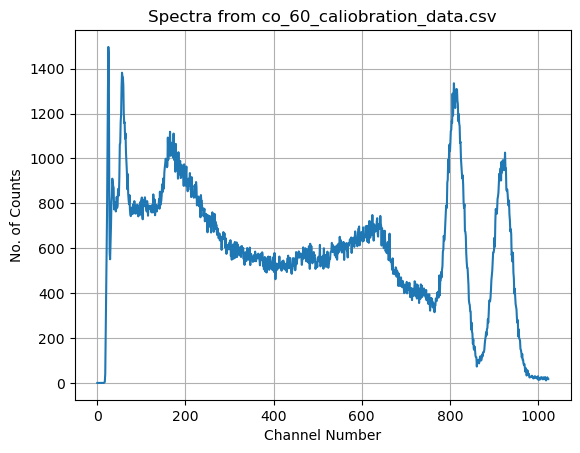

In [4]:
co_60_data_1 = spectra_loader('co_60_caliobration_data.csv')

GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  996.471590 ± 34.097738 (counts)
Center:     811.637268 ± 0.135865 channel no.
Sigma:      16.901833 ± 0.616698
Offset:     289.562357 ± 37.414552

R² value:   0.985286


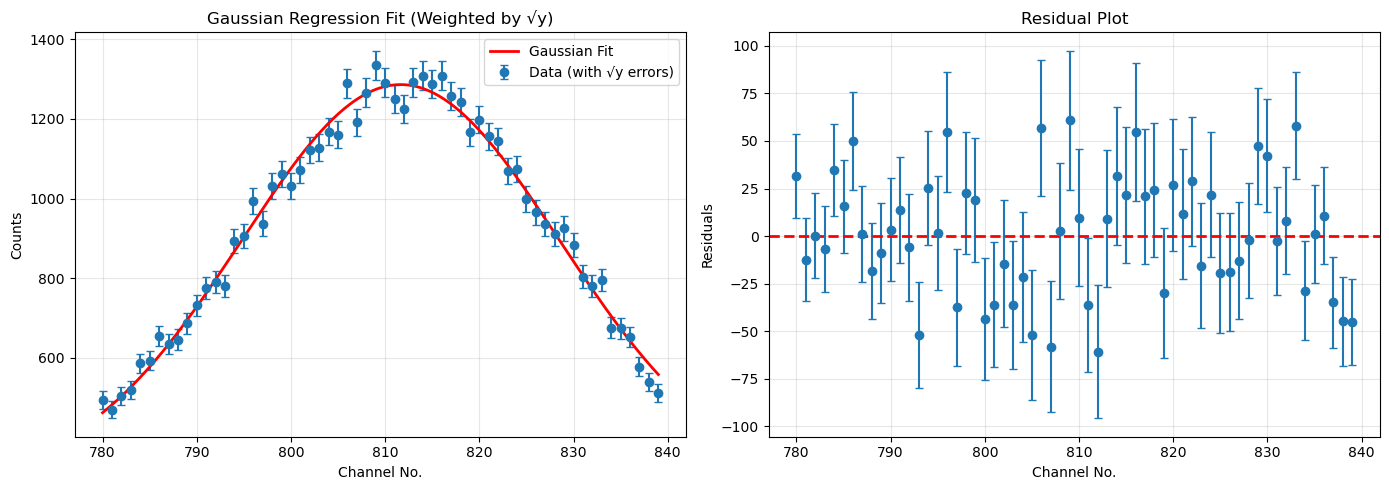

GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  946.657396 ± 7.560963 (counts)
Center:     919.834895 ± 0.118861 channel no.
Sigma:      20.317825 ± 0.236197
Offset:     26.616037 ± 7.215632

R² value:   0.993707


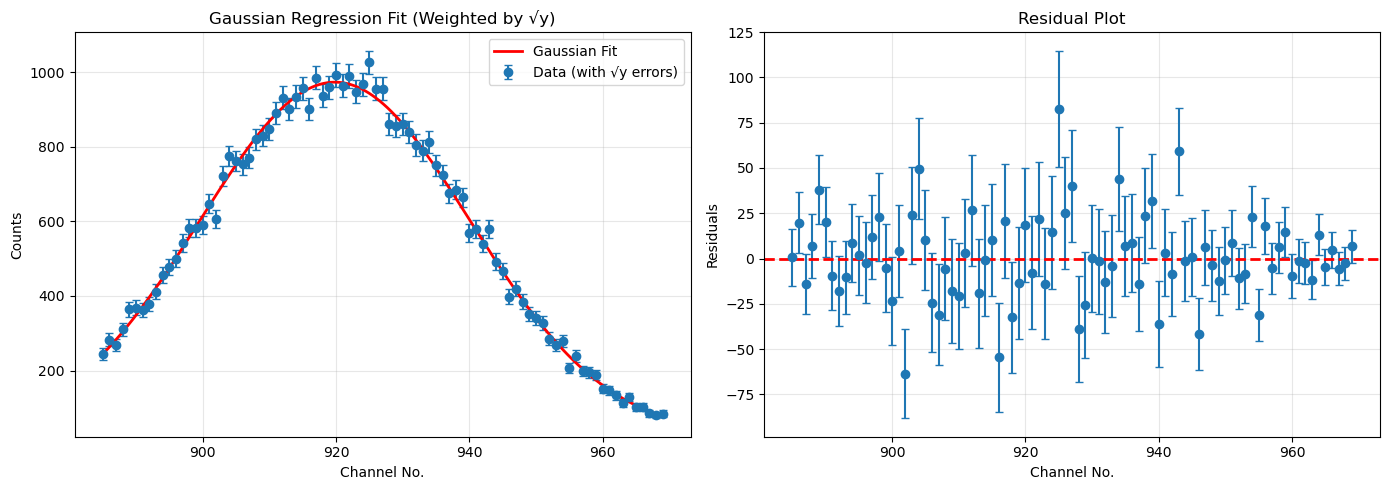

In [5]:
co60_1_peak1 = gaussian_regression(np.asarray(co_60_data_1.iloc[780:840,0]),np.asarray(co_60_data_1.iloc[780:840,1]))
co60_1_peak2 = gaussian_regression(np.asarray(co_60_data_1.iloc[885:970,0]),np.asarray(co_60_data_1.iloc[885:970,1]))


## Find Channel No. to Energy calibration using Co 60:
Co60 peak 1: $1173.208 \pm 0.025$ KeV \
Co60 peak 2: $1332.491 \pm 0.041$ KeV \
Taken from Gamma Ray Energies and Intensities Book

In [6]:
def calibration_co60(co60_peak1, co60_peak2, force_through_zero=False):
    """
    Performs linear calibration of channel vs. energy for Co-60 peaks.
    
    Parameters
    ----------
    co60_peak1, co60_peak2 : dict
        Outputs from gaussian_regression() for two Co-60 peaks (1173 and 1332 keV)
    force_through_zero : bool, optional
        If True, fits y = A*x with B fixed to 0.
    
    Returns
    -------
    A, dA, B, dB : float
        Calibration slope and intercept with uncertainties
    """
    
    # Step 1: Assemble DataFrame
    data = pd.DataFrame({
        "x": [co60_peak1['parameters']['center'], co60_peak2['parameters']['center']],
        "dx": [co60_peak1['uncertainties']['center'], co60_peak2['uncertainties']['center']], 
        "y": [1173.208, 1332.491],
        "dy": [0.025, 0.041]
    })
    
    # Step 2: Define model
    if force_through_zero:
        def model(x, A):
            return A * x
        p0 = [1.0]
    else:
        def model(x, A, B):
            return A * x + B
        p0 = [1.0, 0.0]

    # Step 3: Fit with uncertainties
    popt, pcov = curve_fit(model, data["x"], data["y"], sigma=data["dy"],
                           absolute_sigma=True, p0=p0)
    
    if force_through_zero:
        A, = popt
        dA = np.sqrt(pcov[0, 0])
        B, dB = 0.0, 0.0
    else:
        A, B = popt
        dA, dB = np.sqrt(np.diag(pcov))
    
    # Step 4: Plot fit
    x_fit = np.linspace(min(data["x"]) - 0.2, max(data["x"]) + 0.2, 100)
    y_fit = model(x_fit, *popt)
    
    plt.errorbar(data["x"], data["y"], xerr=data["dx"], yerr=data["dy"],
                 fmt='o', capsize=5, label='Data')
    plt.plot(x_fit, y_fit, 'r-', label='Fit')
    plt.xlabel('Channel')
    plt.ylabel('Energy (keV)')
    plt.title('Co-60 Energy Calibration: E = A·Channel + B')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Step 5: Output results
    print("="*55)
    print("CO-60 ENERGY CALIBRATION RESULTS")
    print("="*55)
    print(f"A = {A:.6e} ± {dA:.6e}")
    print(f"B = {B:.6e} ± {dB:.6e}")
    print("-"*55)
    
    # Diagnostic check for intercept consistency
    if not force_through_zero:
        if abs(B) > 3 * dB:
            print(f"Intercept significantly non-zero (|B| > 3σ): {B:.3f} ± {dB:.3f}")
        elif abs(B) > 10:  # physically large offset
            print(f"Intercept {B:.2f} keV suggests slight non-linearity or offset.")
        else:
            print("Intercept B is consistent with zero within uncertainty.")
    
    return A, dA, B, dB


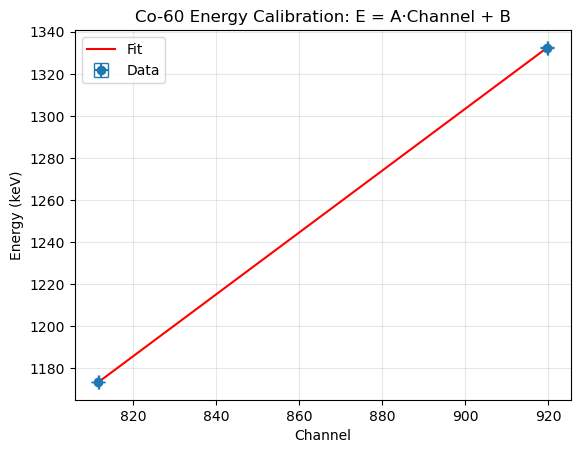

CO-60 ENERGY CALIBRATION RESULTS
A = 1.472149e+00 ± 4.438252e-04
B = -2.164278e+01 ± 3.738501e-01
-------------------------------------------------------
Intercept significantly non-zero (|B| > 3σ): -21.643 ± 0.374


In [7]:
A = calibration_co60(co60_1_peak1, co60_1_peak2)

### Calibration for Day1 is done, Finding gamma Energies for isotopes now

## Na22

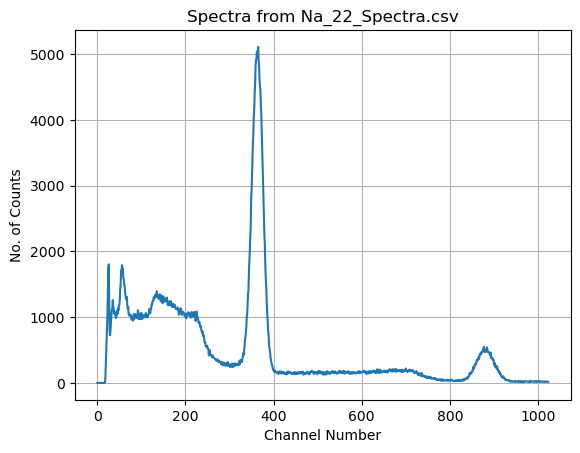

In [8]:
na_22_data = spectra_loader('Na_22_Spectra.csv')

GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  4949.170671 ± 36.812059 (counts)
Center:     363.113464 ± 0.038810 channel no.
Sigma:      12.518877 ± 0.125795
Offset:     89.210556 ± 41.462026

R² value:   0.998108


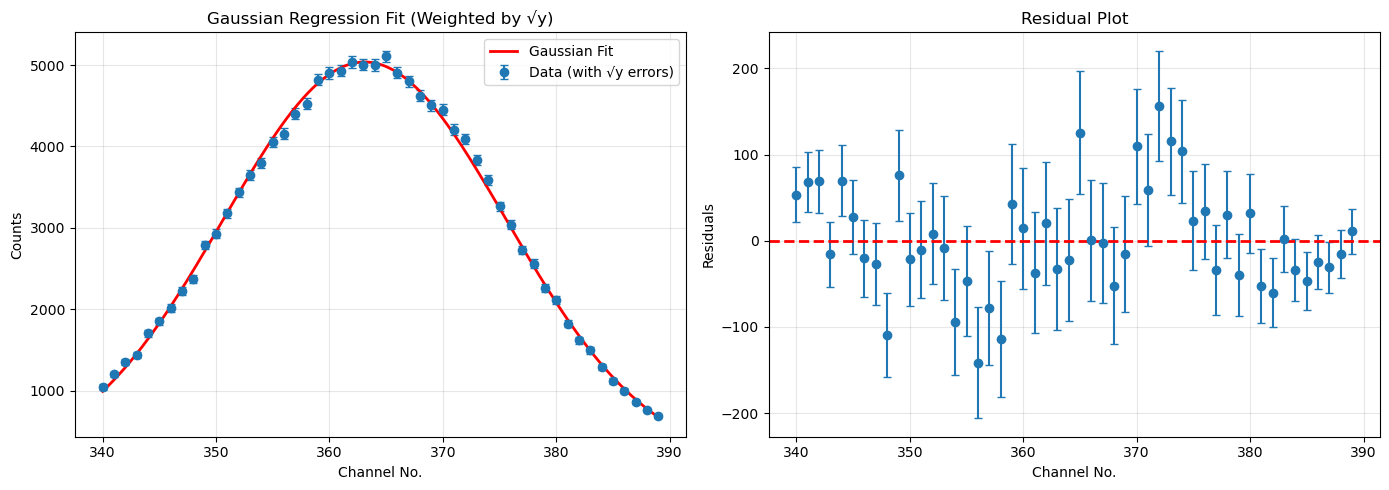

GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  451.749724 ± 35.984726 (counts)
Center:     880.086635 ± 0.197856 channel no.
Sigma:      18.834367 ± 1.376480
Offset:     54.702206 ± 38.559323

R² value:   0.967340


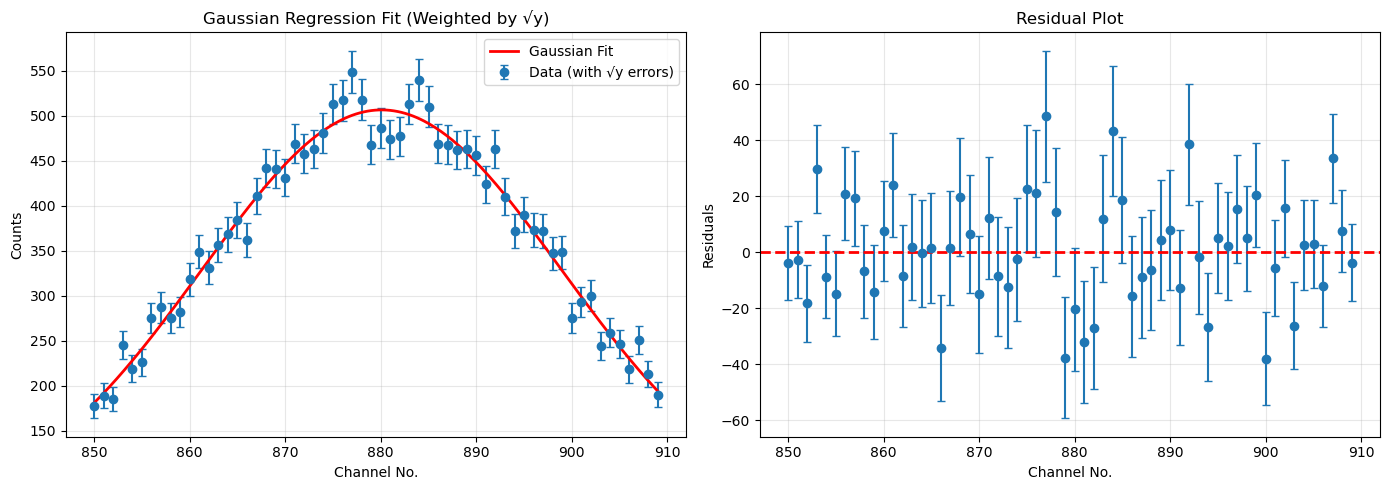

In [9]:
na22_peak1 = gaussian_regression(np.asarray(na_22_data.iloc[340:390,0]),np.asarray(na_22_data.iloc[340:390,1]))
na22_peak2 = gaussian_regression(np.asarray(na_22_data.iloc[850:910,0]),np.asarray(na_22_data.iloc[850:910,1]))

In [10]:
def find_energy_from_cal(A, channel, dchannel):
    energy = A[0] * channel + A[2]
    d_energy = np.sqrt((A[0]*dchannel)**2 + (A[1]*channel)**2 + A[3]**2)
    print(f"Energy = {energy:.4e} ± {d_energy:.4e} KeV")
    return energy, d_energy

In [11]:
na_22_energy1 = find_energy_from_cal(A, na22_peak1['parameters']['center'], na22_peak1['uncertainties']['center'])
na_22_energy2 = find_energy_from_cal(A, na22_peak2['parameters']['center'], na22_peak2['uncertainties']['center'])


Energy = 5.1291e+02 ± 4.1110e-01 KeV
Energy = 1.2740e+03 ± 6.1415e-01 KeV


#### Deviation from Theoretical Values of Na22:
Peak1: $511.006$ KeV \
Peak2: $1274.511 \pm 0.028$ KeV

In [12]:
dev1 = (na_22_energy1[0] - 512.81)/512.81
dev2 = (na_22_energy2[0] - 1273.8)/1273.8
print(f"Deviation of Peak 1 = {dev1:.4%}")
print(f"Deviation of Peak 2 = {dev2:.4%}")

Deviation of Peak 1 = 0.0203%
Deviation of Peak 2 = 0.0138%


## Cd 109

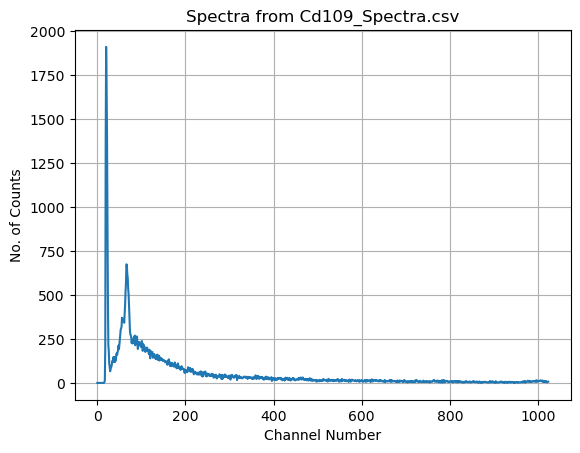

In [13]:
cd_109_data = spectra_loader('Cd109_Spectra.csv')

GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  302.640092 ± 133.558196 (counts)
Center:     67.201185 ± 0.150917 channel no.
Sigma:      2.799749 ± 1.087657
Offset:     358.130511 ± 141.578104

R² value:   0.923124


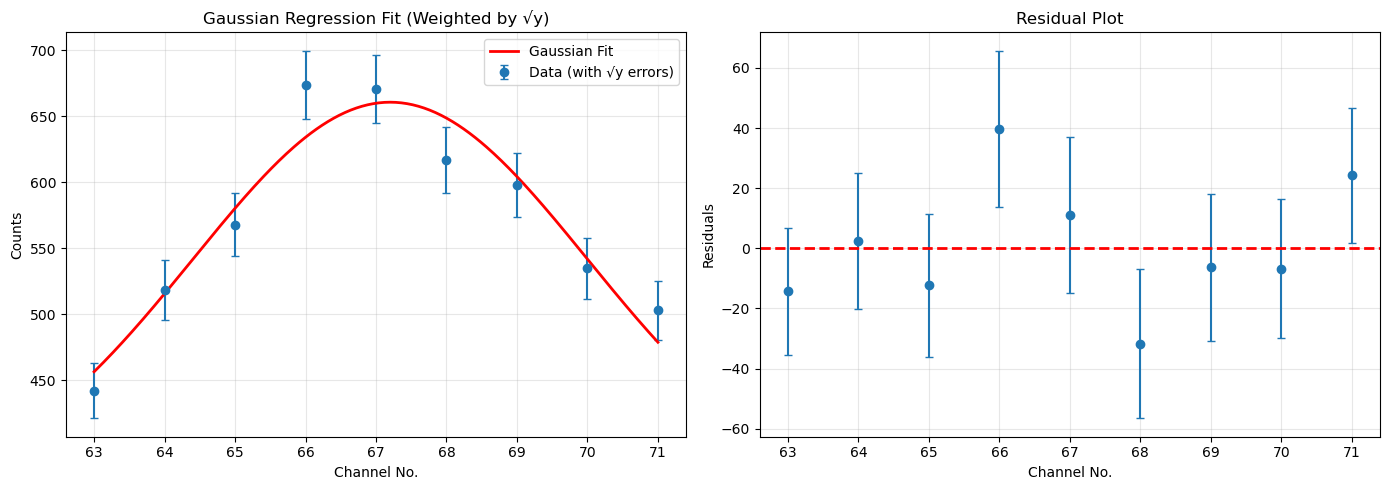

In [14]:
cd109_peak = gaussian_regression(np.asarray(cd_109_data.iloc[63:72,0]),np.asarray(cd_109_data.iloc[63:72,1]))

In [15]:
cd_109_energy1 = find_energy_from_cal(A, cd109_peak['parameters']['center'], cd109_peak['uncertainties']['center'])

Energy = 7.7287e+01 ± 4.3591e-01 KeV


This is deviating a lot from the theoretical value of $88$ KeV.

In [16]:
dev1 = (cd_109_energy1[0] - 88)/88
print(f"Deviation of Peak 1 = {dev1:.4%}")

Deviation of Peak 1 = -12.1735%


# Day 2 (10/23)

### Calibration Done! Now, Attenuation using Cs 137 spectrum
We will take the spectrum at different thicknesses of metals and calculate the counts per second at the Cs137 peak to fit it in the attenuation equation.

In [17]:
def get_counts_ps(fit_dict, time):
    counts = (fit_dict["parameters"]["amplitude"] + fit_dict["parameters"]["offset"])/time
    dcounts = np.sqrt((fit_dict["uncertainties"]["amplitude"]/time)**2 + (fit_dict["uncertainties"]["offset"]/time)**2 + (fit_dict["parameters"]["amplitude"] + fit_dict["parameters"]["offset"])*0.01/(time**2))
    print(f"Total Counts = {counts:.4e} ± {dcounts:.4e}")
    return counts, dcounts


# Aluminium

In [18]:
al_counts_ps = []
al_dcounts_ps = []
al_thicknesses = [0, 6.74, 12.85, 25.66, 46.25, 76.65]  # in mm
al_dthicknesses = [0.01]*6  # assuming 0.1 mm precision in thickness measurements
al_csv_files_ordered = ['cs_137_10_23_9_5_cm_empty.csv','cs_127_10_13_9.5cm674mm.csv', 'cs_127_10_13_9.6cm1285mm.csv', 'cs_137_10_23_9.5cm2566mm.csv', 'cs_137_10_13_9.5cm4625mm.csv', 'cs_137_10_23_9.5cm7865mm.csv']

Total Live Time 420.8
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  393.052687 ± 6.655608 (counts)
Center:     411.434389 ± 0.145982 channel no.
Sigma:      12.591106 ± 0.328647
Offset:     51.790603 ± 6.692717

R² value:   0.984760


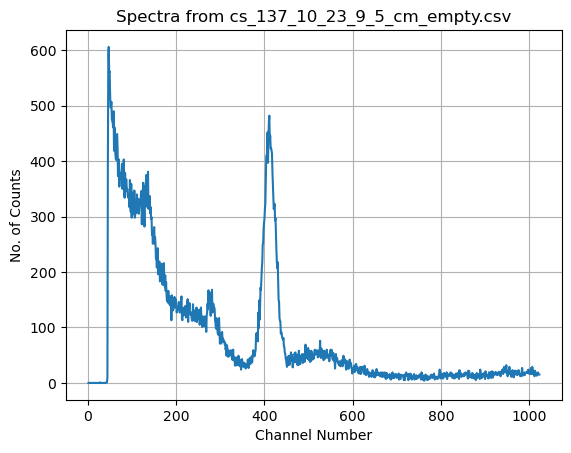

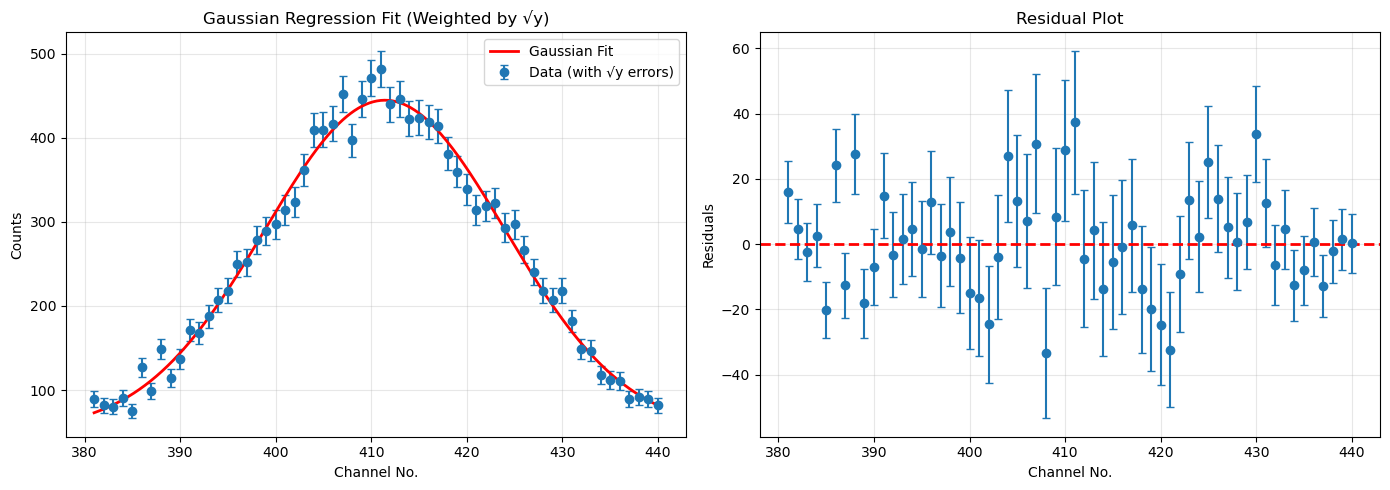

Total Counts = 1.0571e+00 ± 2.2984e-02
Total Live Time 433.56
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  351.900669 ± 6.225817 (counts)
Center:     412.726253 ± 0.156922 channel no.
Sigma:      12.675872 ± 0.335747
Offset:     48.352646 ± 6.078791

R² value:   0.976585


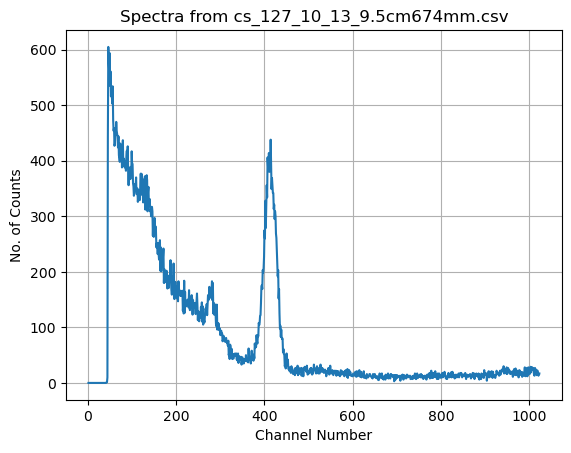

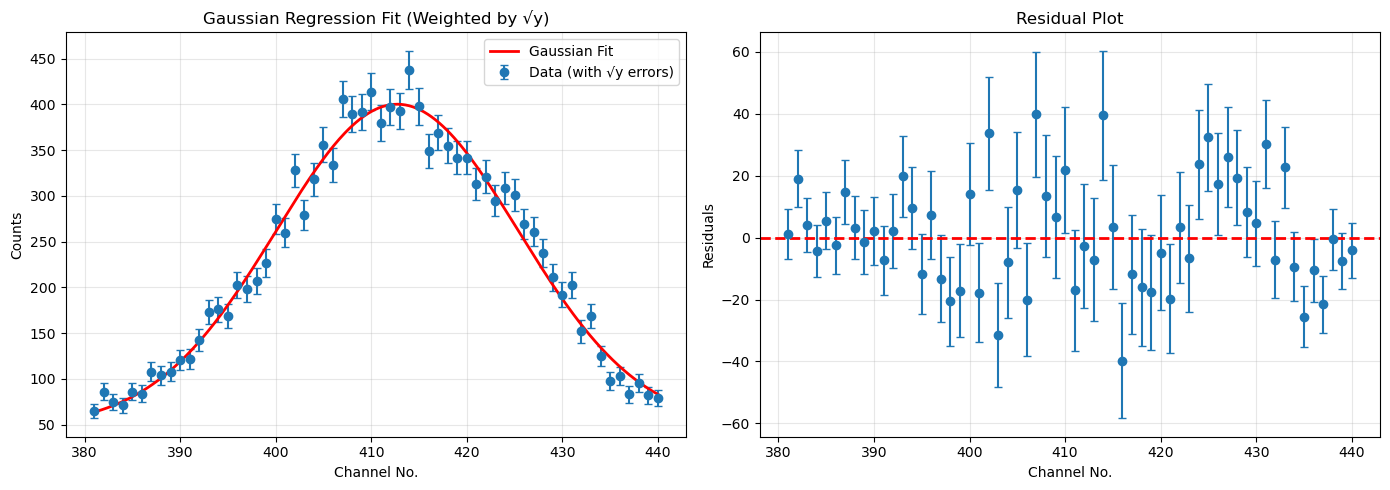

Total Counts = 9.2318e-01 ± 2.0593e-02
Total Live Time 422.06
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  303.970429 ± 5.505180 (counts)
Center:     414.235397 ± 0.172837 channel no.
Sigma:      12.735602 ± 0.329974
Offset:     43.706556 ± 4.969681

R² value:   0.974143


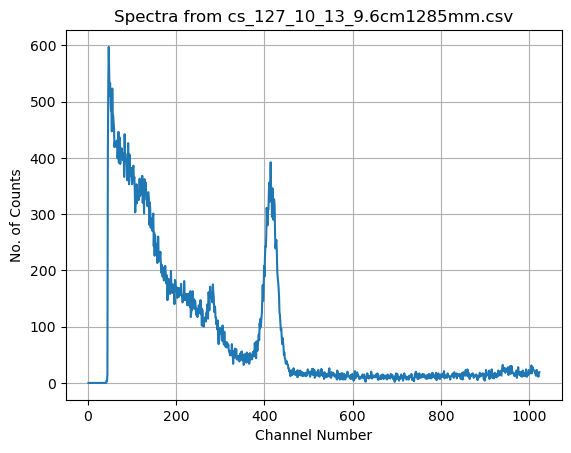

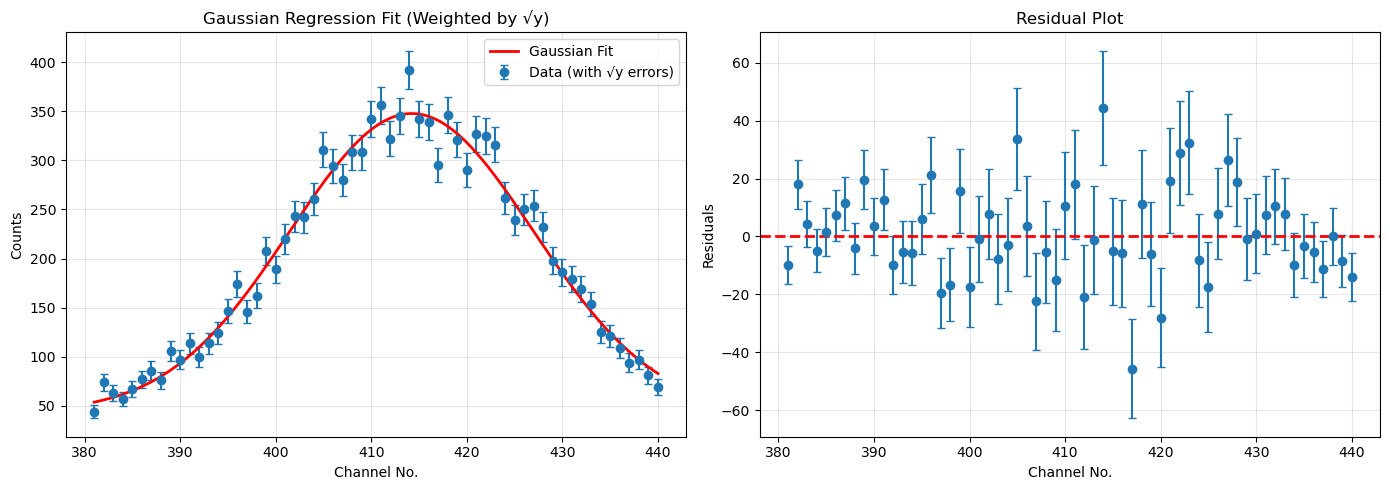

Total Counts = 8.2376e-01 ± 1.8119e-02
Total Live Time 420.53
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  221.003727 ± 4.936108 (counts)
Center:     414.958022 ± 0.215789 channel no.
Sigma:      11.977180 ± 0.375823
Offset:     57.819564 ± 4.146410

R² value:   0.978971


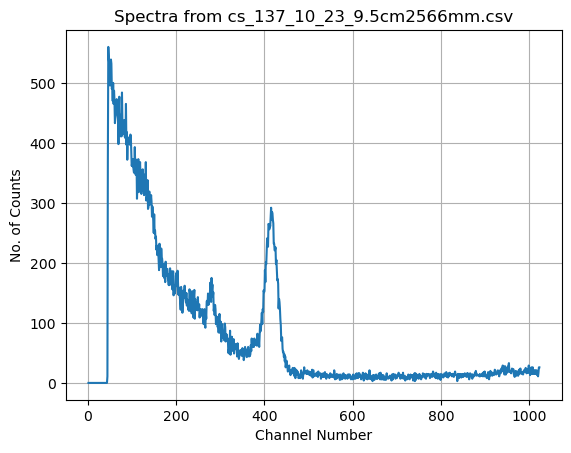

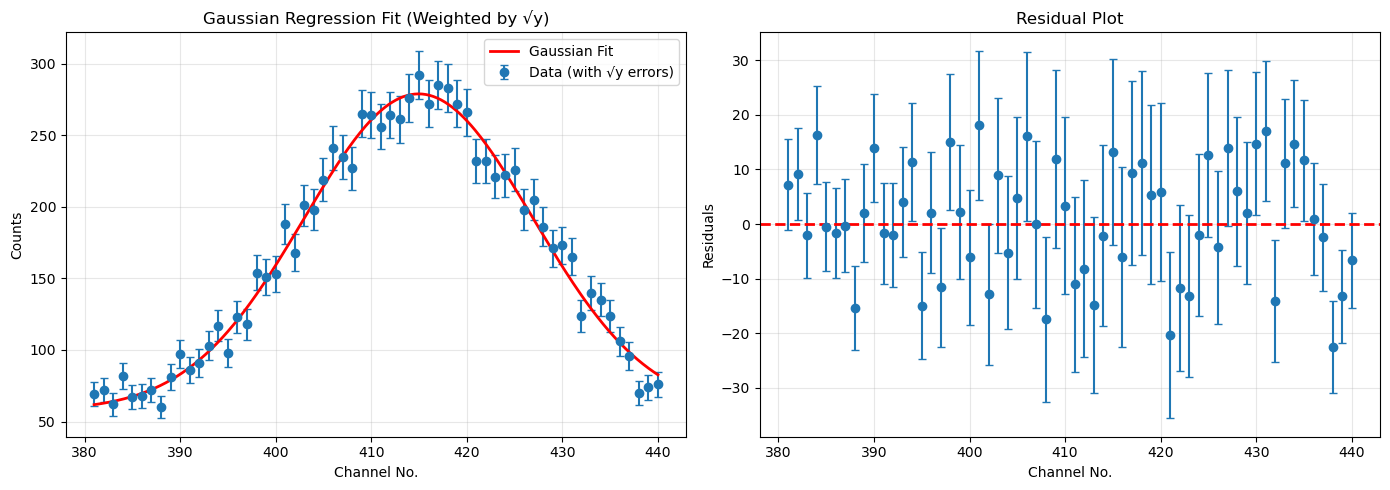

Total Counts = 6.6303e-01 ± 1.5835e-02
Total Live Time 420.54
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  125.030434 ± 4.142267 (counts)
Center:     414.836317 ± 0.309418 channel no.
Sigma:      10.508938 ± 0.473216
Offset:     63.639254 ± 3.033808

R² value:   0.945391


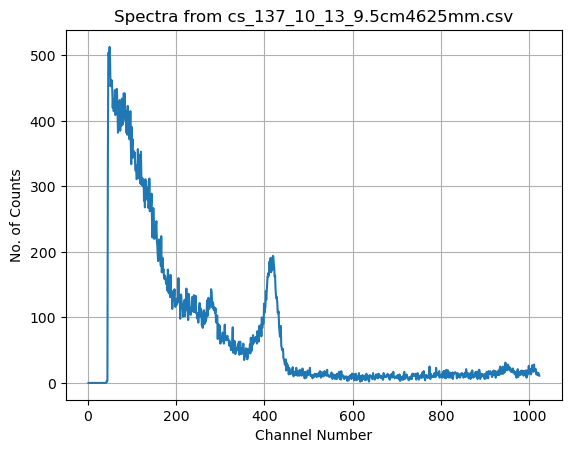

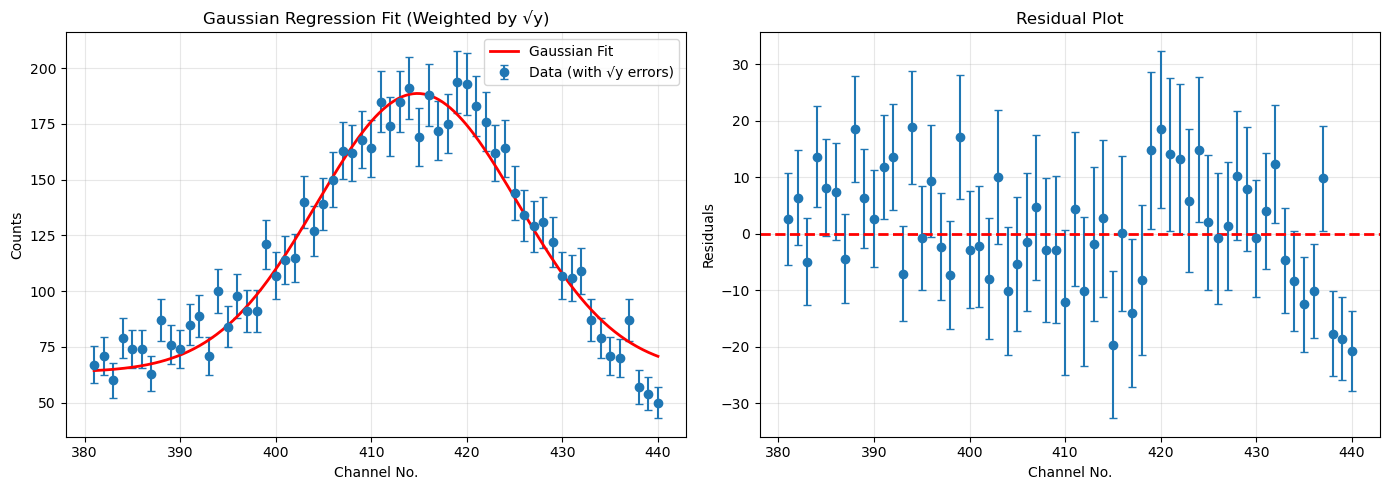

Total Counts = 4.4864e-01 ± 1.2638e-02
Total Live Time 420.41
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  65.927860 ± 3.693427 (counts)
Center:     413.189276 ± 0.488536 channel no.
Sigma:      11.846965 ± 0.975025
Offset:     43.321550 ± 3.581908

R² value:   0.807095


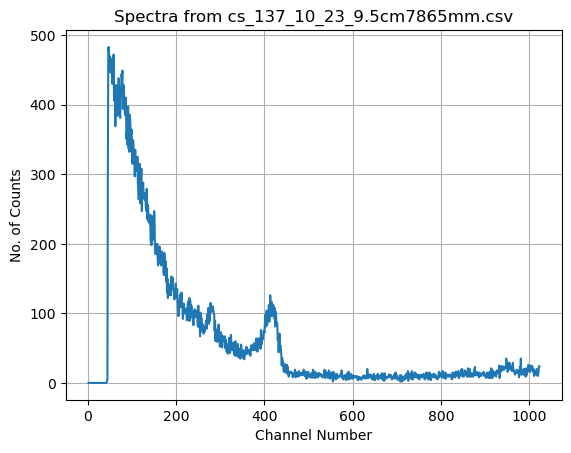

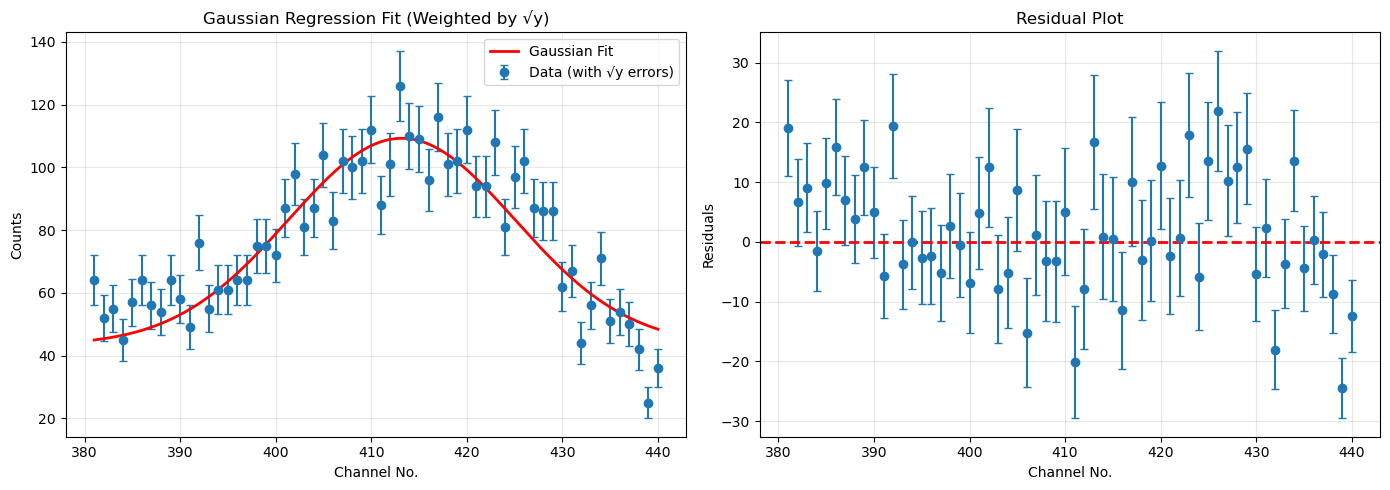

Total Counts = 2.5986e-01 ± 1.2488e-02


In [19]:
# Calculating stuff for all Al files
for file in al_csv_files_ordered:
    al_data = spectra_loader(file)
    al_time = read_time(file)
    print("Total Live Time", al_time)
    al_peak = gaussian_regression(np.asarray(al_data.iloc[380:440,0]),np.asarray(al_data.iloc[380:440,1]))
    al_counts = get_counts_ps(al_peak, al_time)
    al_counts_ps.append(al_counts[0])
    al_dcounts_ps.append(al_counts[1])

In [20]:
print("Aluminium Thicknesses (mm):", al_thicknesses)
print("Aluminium Counts per second:", al_counts_ps)
print("Aluminium dCounts per second:", al_dcounts_ps)

Aluminium Thicknesses (mm): [0, 6.74, 12.85, 25.66, 46.25, 76.65]
Aluminium Counts per second: [1.0571370948817507, 0.9231786028238046, 0.823761989241372, 0.6630282990970493, 0.44863672338179506, 0.25986396636700915]
Aluminium dCounts per second: [0.02298361439140692, 0.020593062115468845, 0.018119036229663932, 0.015835462886141793, 0.012638475800711119, 0.012488140351605847]


In [21]:

def fit_attenuation(thicknesses, counts_ps, dcounts_ps, dthicknesses, material_name="Material"):
    """
    Fits the exponential attenuation model I = I0 * exp(-μx)
    with C fixed to 0 (no offset term).
    """

    # Ensure NumPy arrays for safety
    thicknesses = np.asarray(thicknesses, dtype=float)
    counts_ps = np.asarray(counts_ps, dtype=float)
    dcounts_ps = np.asarray(dcounts_ps, dtype=float)
    dthicknesses = np.asarray(dthicknesses, dtype=float)

    # Define model (C fixed = 0)
    def attenuation_model(x, I0, mu):
        return I0 * np.exp(-mu * x)

    # Initial guesses and bounds
    I0_guess = np.max(counts_ps)
    mu_guess = 0.01
    p0 = [I0_guess, mu_guess]
    bounds = ([0, 0], [np.inf, 10])

    # Perform curve fitting
    popt, pcov = curve_fit(
        attenuation_model,
        thicknesses,
        counts_ps,
        p0=p0,
        bounds=bounds,
        sigma=dcounts_ps,
        absolute_sigma=True,
        maxfev=10000
    )

    # Extract results
    I0, mu = popt
    dI0, dmu = np.sqrt(np.diag(pcov))

    # Compute goodness of fit
    residuals = counts_ps - attenuation_model(thicknesses, *popt)
    chi2 = np.sum((residuals / dcounts_ps) ** 2)
    dof = len(thicknesses) - len(popt)
    chi2_red = chi2 / dof

    # Plot
    x_fit = np.linspace(0, max(thicknesses) * 1.1, 300)
    y_fit = attenuation_model(x_fit, *popt)

    plt.figure(figsize=(7,5))
    plt.errorbar(thicknesses, counts_ps, yerr=dcounts_ps, xerr=dthicknesses,
                 fmt='o', capsize=3, label='Data', color='blue')
    plt.plot(x_fit, y_fit, color='red', label='Best Fit (C=0)')
    plt.xlabel("Thickness (mm)")
    plt.ylabel("Counts per second")
    plt.title(f"Gamma Attenuation in {material_name} (C=0)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print results
    print(f"Fit results for {material_name} (C=0)")
    print(f"I0 = {I0:.3f} ± {dI0:.3f}")
    print(f"μ  = {mu:.5f} ± {dmu:.5f} mm⁻¹")
    print(f"Reduced χ² = {chi2_red:.2f} (dof = {dof})")

    return {
        "I0": (I0, dI0),
        "mu": (mu, dmu),
        "chi2_red": chi2_red,
        "covariance": pcov
    }


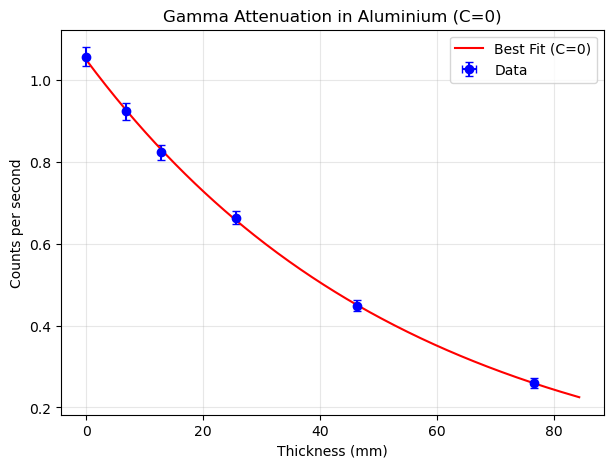

Fit results for Aluminium (C=0)
I0 = 1.050 ± 0.015
μ  = 0.01827 ± 0.00053 mm⁻¹
Reduced χ² = 0.12 (dof = 4)


{'I0': (1.0497393702707873, 0.014751385913536754),
 'mu': (0.018273429386081792, 0.0005284639740301053),
 'chi2_red': 0.11865939259839765,
 'covariance': array([[2.17603386e-04, 5.37030503e-06],
        [5.37030503e-06, 2.79274172e-07]])}

In [22]:
fit_attenuation(al_thicknesses, al_counts_ps, al_dcounts_ps, al_dthicknesses, material_name="Aluminium")

## Analysis: Aluminium Attenuation with C = 0

With the offset term fixed to zero, the fitted parameters are:

- $I_0 = 1.050 \pm 0.015$ counts/s  
- $\mu = 0.01827 \pm 0.00053$ mm⁻¹  
- Reduced $\chi^2 = 0.12$ (dof = 4)

### Physical Meaning

Fixing $C = 0$ assumes **perfect background subtraction**, meaning all detected counts originate from the primary gamma beam passing through aluminium.  
The fit still yields a smooth exponential decay, confirming that background contributions were negligible.

The **attenuation coefficient** $\mu = 0.0183$ mm⁻¹ indicates that the beam intensity decreases by about 1.8% per millimeter of aluminium.

### Sanity Check

- **Half-Value Layer (HVL):**  
  $ \text{HVL} = \ln(2) / \mu = 37.9$ mm  \
  The count rate should drop by half for every ~3.8 cm of aluminium.

### Interpretation

The exponential behavior is clear and physically consistent with gamma attenuation through aluminium.  


# Tungsten

In [23]:
sn_counts_ps = []
sn_dcounts_ps = []
sn_thicknesses = [0, 0.67, 5.61, 6.28]  # in mm
sn_dthicknesses = [0.01]*4  # assuming 0.1 mm precision in thickness measurements
sn_csv_files_ordered = ['cs_137_1.7cm.csv', 'cs_137_1.7cm067mm.csv', 'cs_137_1.7cm561mm.csv', 'cs_137_1.7cm_628.csv']

Total Live Time 420.8
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  4289.542006 ± 17.637705 (counts)
Center:     418.225793 ± 0.051900 channel no.
Sigma:      14.492940 ± 0.087910
Offset:     234.544652 ± 14.953791

R² value:   0.998561


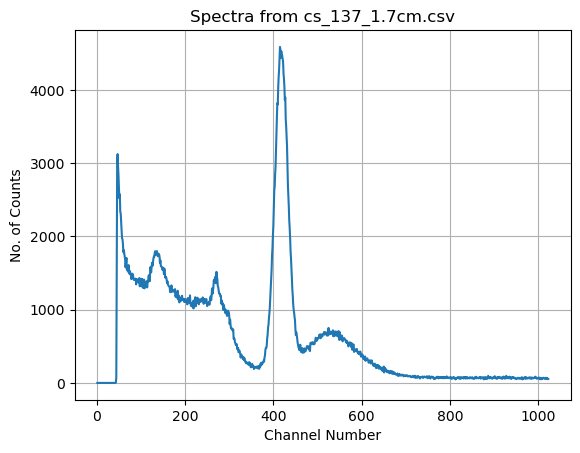

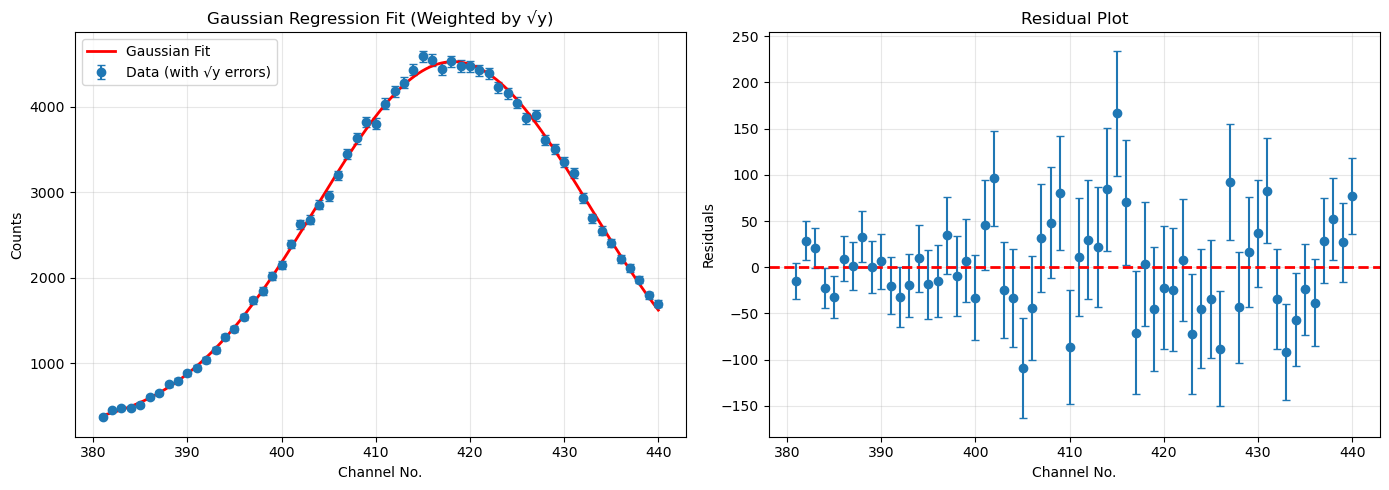

Total Counts = 1.0751e+01 ± 5.7229e-02
Total Live Time 420.14
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  3764.178445 ± 17.302635 (counts)
Center:     416.956928 ± 0.052576 channel no.
Sigma:      14.178709 ± 0.094055
Offset:     227.082462 ± 15.264509

R² value:   0.997863


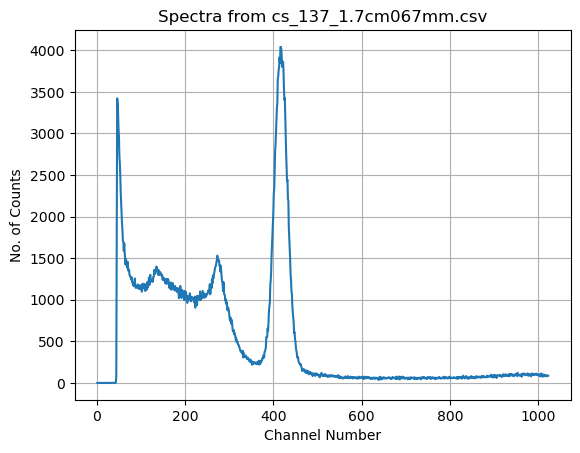

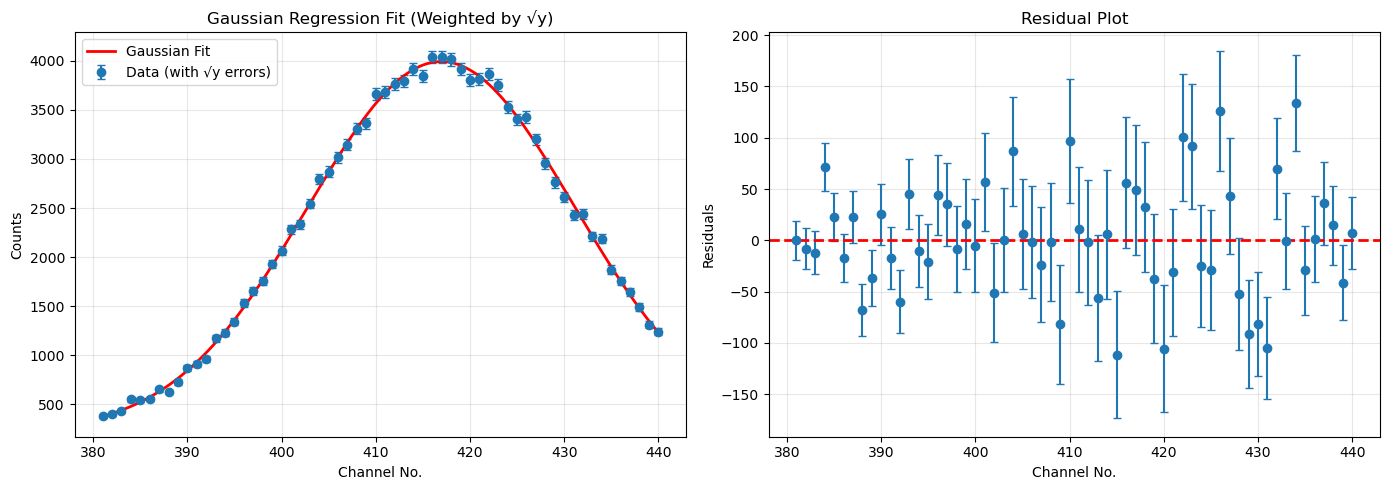

Total Counts = 9.4998e+00 ± 5.6940e-02
Total Live Time 420.4
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  1696.724658 ± 14.538987 (counts)
Center:     414.249023 ± 0.077540 channel no.
Sigma:      13.346109 ± 0.164867
Offset:     276.130343 ± 14.408462

R² value:   0.995806


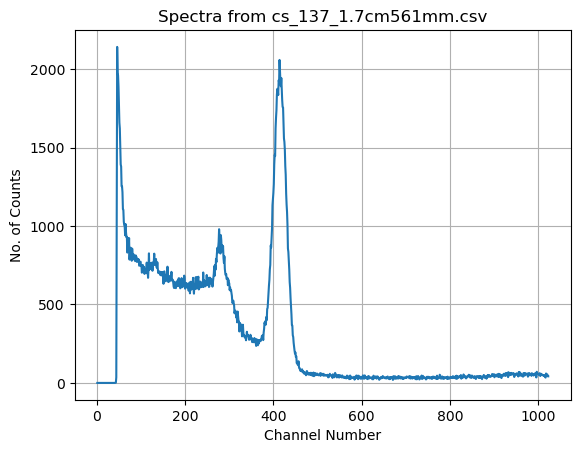

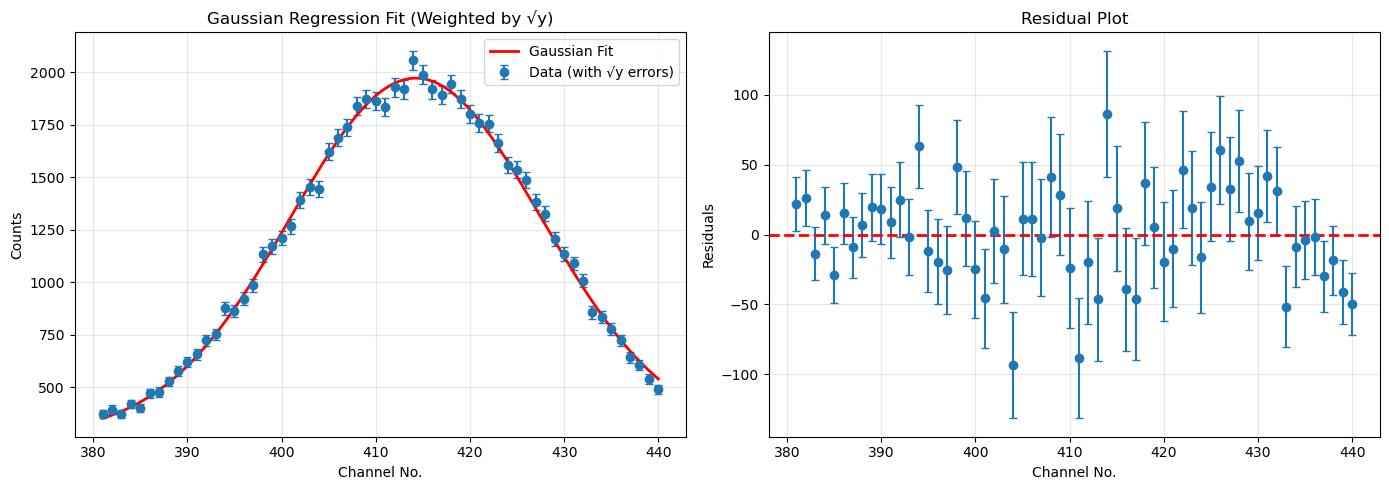

Total Counts = 4.6928e+00 ± 4.9823e-02
Total Live Time 420.46
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  1520.370008 ± 13.911211 (counts)
Center:     414.186837 ± 0.081978 channel no.
Sigma:      13.415606 ± 0.176652
Offset:     244.266624 ± 13.896331

R² value:   0.993254


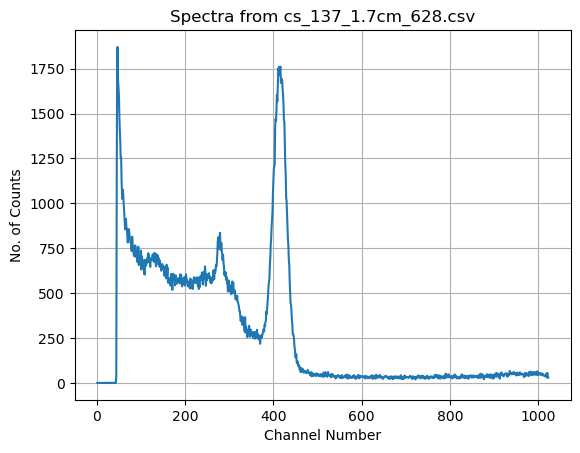

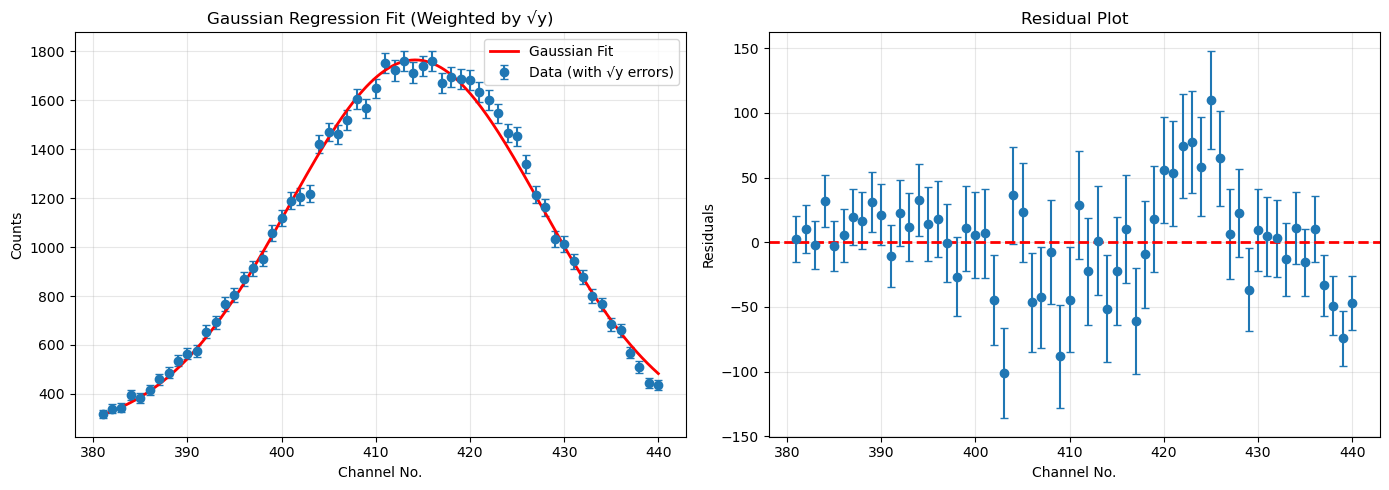

Total Counts = 4.1969e+00 ± 4.7821e-02


In [24]:
# Calculating stuff for all Al files
for file in sn_csv_files_ordered:
    sn_data = spectra_loader(file)
    sn_time = read_time(file)
    print("Total Live Time", sn_time)
    sn_peak = gaussian_regression(np.asarray(sn_data.iloc[380:440,0]),np.asarray(sn_data.iloc[380:440,1]))
    sn_counts = get_counts_ps(sn_peak, sn_time)
    sn_counts_ps.append(sn_counts[0])
    sn_dcounts_ps.append(sn_counts[1])

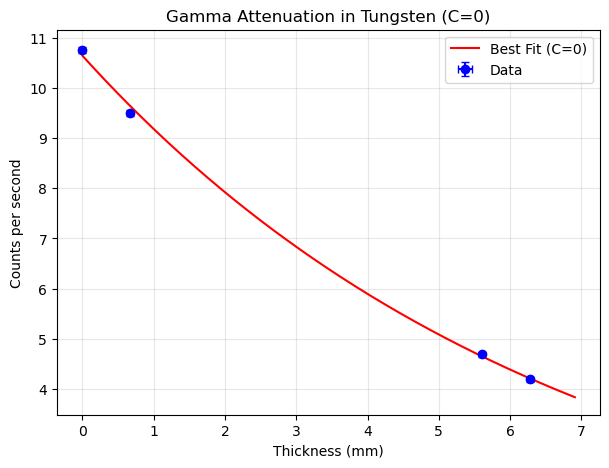

Fit results for Tungsten (C=0)
I0 = 10.640 ± 0.045
μ  = 0.14756 ± 0.00154 mm⁻¹
Reduced χ² = 5.27 (dof = 2)


{'I0': (10.640312051078231, 0.04468889233402355),
 'mu': (0.1475625395395808, 0.0015397100771529979),
 'chi2_red': 5.2709577790215985,
 'covariance': array([[1.99709710e-03, 3.69660633e-05],
        [3.69660633e-05, 2.37070712e-06]])}

In [25]:
fit_attenuation(sn_thicknesses, sn_counts_ps, sn_dcounts_ps, sn_dthicknesses, material_name="Tungsten")

## Analysis: Tungsten Attenuation with C = 0

- $I_0 = 10.640 \pm 0.045$ counts/s  
- $\mu = 0.14756 \pm 0.00154$ mm⁻¹  
- Reduced $\chi^2 = 5.27$ (dof = 2)

### Physical Meaning

For tungsten, the large attenuation coefficient $\mu = 0.1476$ mm⁻¹ reflects its **high atomic number (Z = 74)** and density, both of which strongly enhance photoelectric absorption and Compton scattering for gamma photons.  
This means the transmitted intensity falls off rapidly with even a few millimeters of material.

### Sanity Check

- **Half-Value Layer (HVL):**  
  $ \text{HVL} = \ln(2) / \mu = 4.70$ mm  
  → The count rate should halve every ~4.7 mm of tungsten.

### Interpretation

The data show the expected steep exponential decay, confirming tungsten’s strong shielding capability.  
The high $\chi^2$ likely arises from **systematic effects**—for instance, scattered photons entering the NaI detector or misalignment at higher thicknesses.  
Despite that, the extracted $\mu$ value is physically sensible and consistent with tungsten being over **8× more attenuating than aluminium**, validating both the fitting method and detector response.

# Lead


In [26]:
pb_counts_ps = []
pb_dcounts_ps = []
pb_thicknesses = [0, 1.92, 6.13, 12.27]  # in mm
pb_dthicknesses = [0.01]*4  # assuming 0.1 mm precision in thickness measurements
pb_csv_files_ordered = ['cs_137_4.7cm.csv', 'cs_137_4.7cm192mm.csv', 'cs_137_4.7cm613mm.csv', 'cs_137_4.7cm1227mm.csv']

Total Live Time 420.29
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  1179.598084 ± 12.049240 (counts)
Center:     413.654711 ± 0.088049 channel no.
Sigma:      14.091904 ± 0.208029
Offset:     72.024225 ± 12.578342

R² value:   0.995479


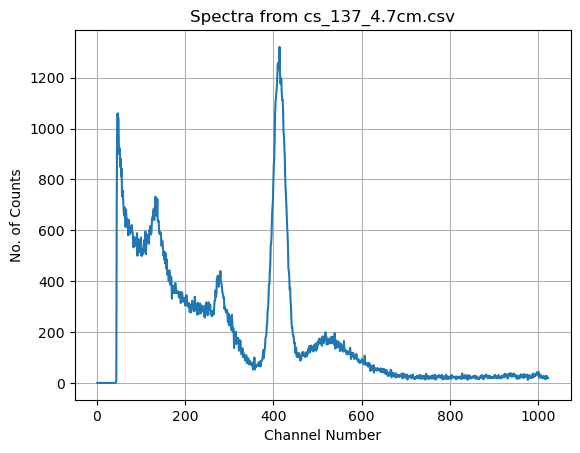

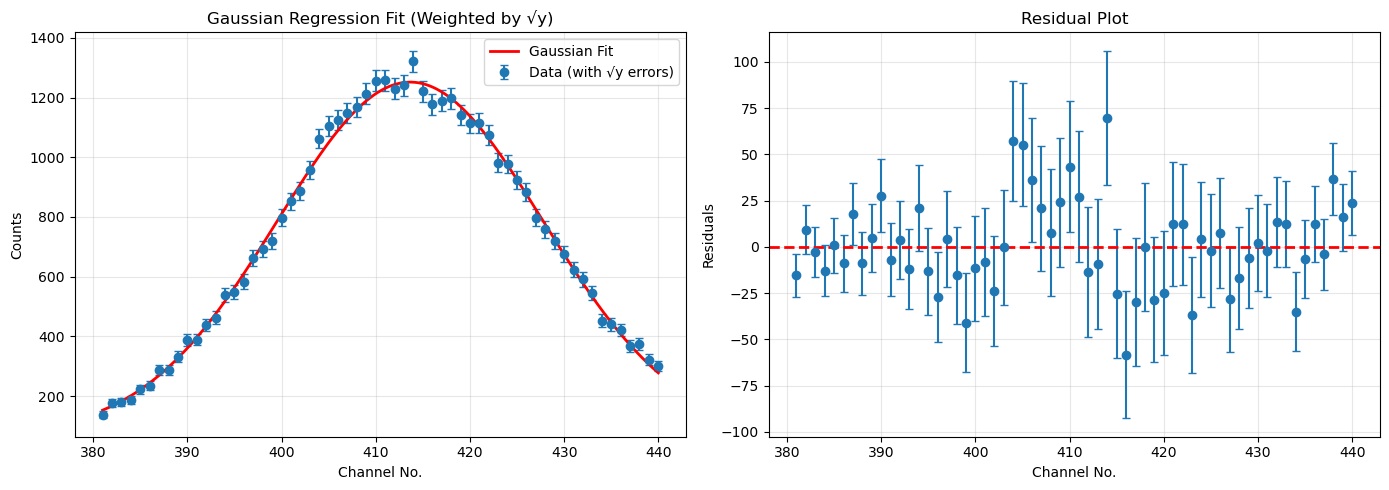

Total Counts = 2.9780e+00 ± 4.2290e-02
Total Live Time 444.98
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  1005.536191 ± 10.073361 (counts)
Center:     413.276987 ± 0.094900 channel no.
Sigma:      13.489208 ± 0.195321
Offset:     88.943009 ± 9.698664

R² value:   0.994575


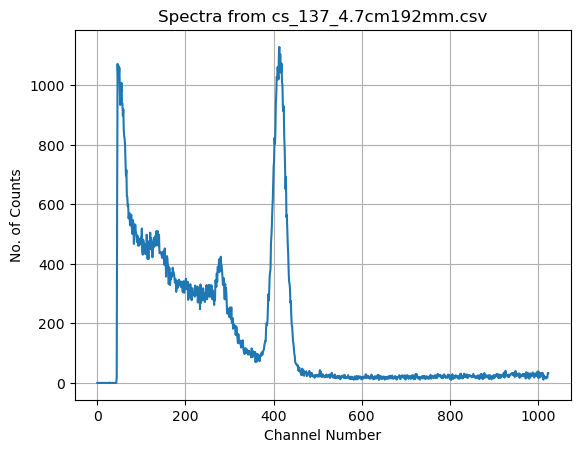

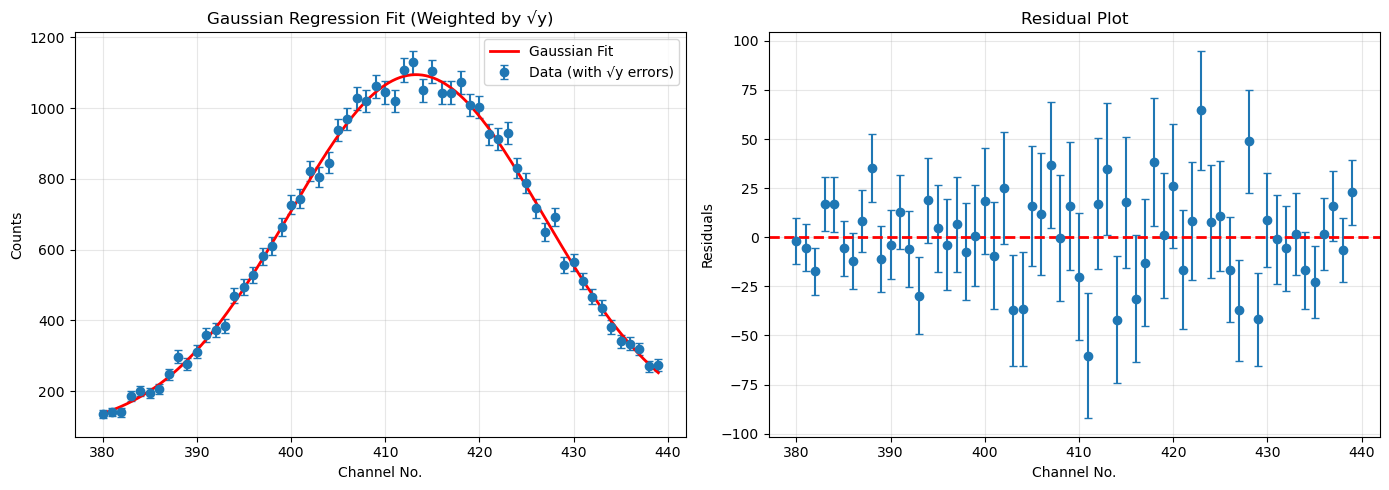

Total Counts = 2.4596e+00 ± 3.2292e-02
Total Live Time 420.05
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  569.432781 ± 8.050670 (counts)
Center:     412.340457 ± 0.126936 channel no.
Sigma:      12.862099 ± 0.268547
Offset:     85.566796 ± 7.854458

R² value:   0.987358


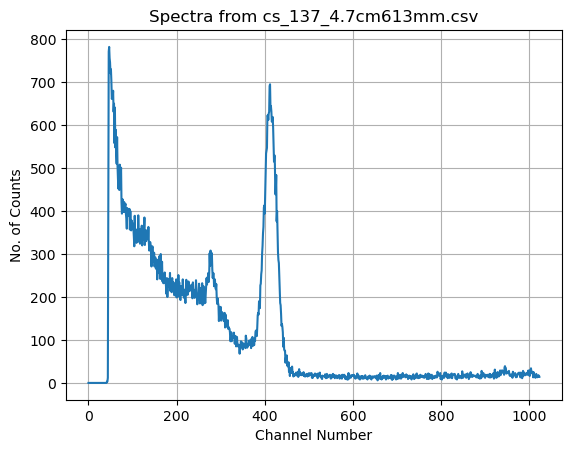

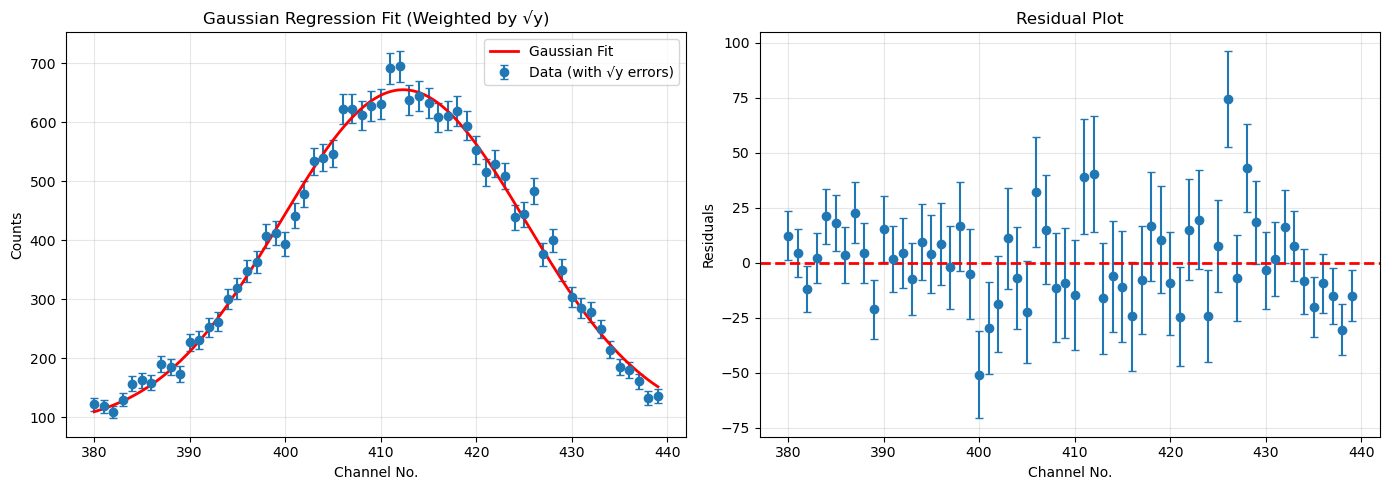

Total Counts = 1.5593e+00 ± 2.7461e-02
Total Live Time 421.13
GAUSSIAN REGRESSION RESULTS (with Poisson weighting)
Amplitude:  272.721649 ± 5.939385 (counts)
Center:     412.213774 ± 0.193964 channel no.
Sigma:      12.457059 ± 0.403996
Offset:     66.371801 ± 5.777321

R² value:   0.970398


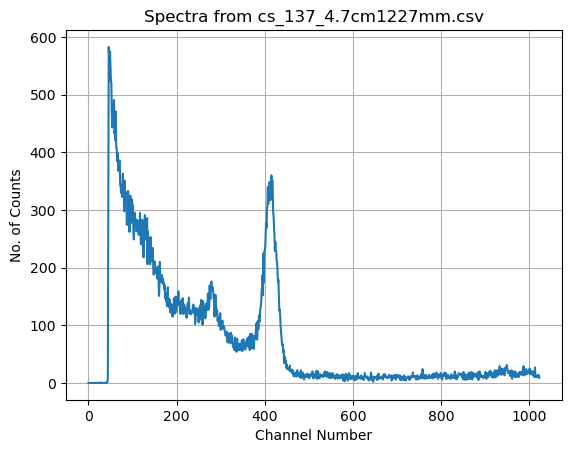

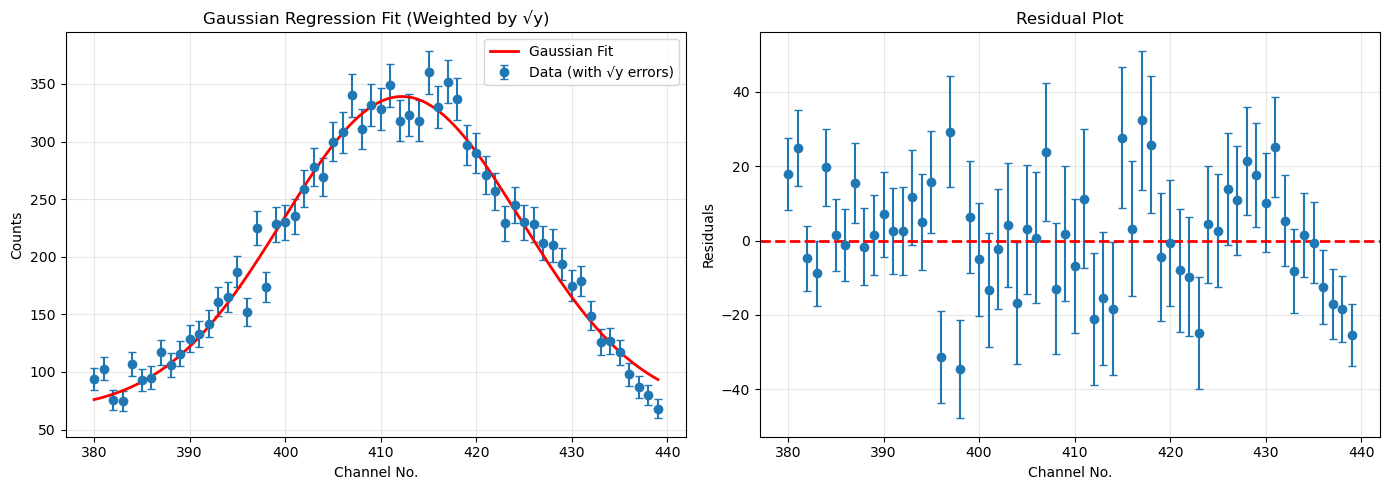

Total Counts = 8.0520e-01 ± 2.0155e-02


In [27]:
for file in pb_csv_files_ordered:
    pb_data = spectra_loader(file)
    pb_time = read_time(file)
    print("Total Live Time", pb_time)
    pb_peak = gaussian_regression(np.asarray(pb_data.iloc[380:440,0]),np.asarray(pb_data.iloc[380:440,1]))
    pb_counts = get_counts_ps(pb_peak, pb_time)
    pb_counts_ps.append(pb_counts[0])
    pb_dcounts_ps.append(pb_counts[1])

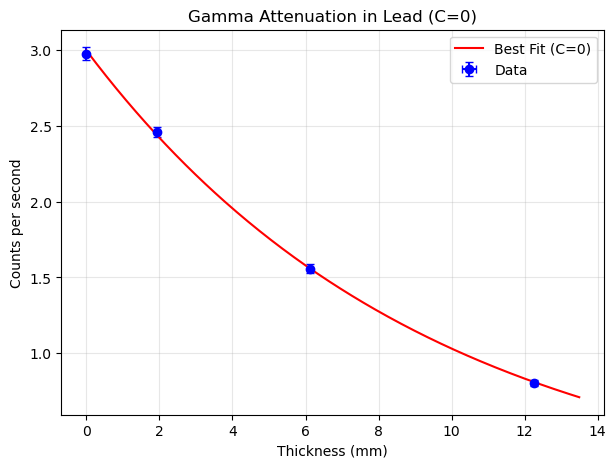

Fit results for Lead (C=0)
I0 = 2.999 ± 0.032
μ  = 0.10678 ± 0.00213 mm⁻¹
Reduced χ² = 0.27 (dof = 2)


{'I0': (2.9985829297789635, 0.031692034034828766),
 'mu': (0.10678429915106688, 0.0021273062942009685),
 'chi2_red': 0.2727570645606439,
 'covariance': array([[1.00438502e-03, 4.39724937e-05],
        [4.39724937e-05, 4.52543207e-06]])}

In [28]:
fit_attenuation(pb_thicknesses, pb_counts_ps, pb_dcounts_ps, pb_dthicknesses, material_name="Lead")

## Analysis: Lead Attenuation with C = 0

- $I_0 = 2.999 \pm 0.032$ counts/s  
- $\mu = 0.10678 \pm 0.00213$ mm⁻¹  
- Reduced $\chi^2 = 0.27$ (dof = 2)

### Physical Meaning

Lead, being a high-Z and dense material (Z = 82, ρ ≈ 11.3 g/cm³), shows very strong attenuation for gamma rays.  
The large attenuation coefficient $\mu = 0.1068$ mm⁻¹ indicates that intensity drops steeply even for thin sheets of lead — a signature of its effectiveness as a gamma shield.

### Sanity Check

- **Half-Value Layer (HVL):**  
  $ \text{HVL} = \ln(2) / \mu = 6.49$ mm  
  Each additional ~6.5 mm of lead reduces the transmitted count rate by half.

### Interpretation

The measured $\mu$ confirms lead’s **high shielding efficiency**, roughly **6× that of aluminium**.  
Overall, the lead results align well with expectations: even thin layers provide substantial gamma attenuation, demonstrating the detector and analysis procedure are functioning consistently across materials.